In [1]:
import warnings
import os
import time
import numpy as np
import pandas as pd
import scikitplot as skplt
from scipy import interp
from scipy import interp
from itertools import cycle
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Model
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('seaborn-paper')

Using TensorFlow backend.
/home/francisanokye/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
test_data_path = '/home/francisanokye/AIMS/Bitbucket/image-classification/trial_image_data/Test'

img_width, img_height = 299, 299
batch_size = 20
np.random.seed(0)

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for prediction
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 800 images belonging to 8 classes.


In [4]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())

# Get the predictions from the model using the generator
model = load_model('InceptionV3model.h5')
predictions = model.predict_generator(
    test_generator, steps=test_generator.samples//test_generator.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("Ratio of misclassified images = {}/{}".format(len(errors), test_generator.samples))
correct = np.where(predicted_classes == ground_truth)[0]
print("Ratio of correctly classified images = {}/{}".format(len(correct),
                                                            test_generator.samples))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
40/40 [==============================] - 542s    
Ratio of misclassified images = 24/800
Ratio of correctly classified images = 776/800


AxesSubplot(0.125,0.125;0.62x0.755)


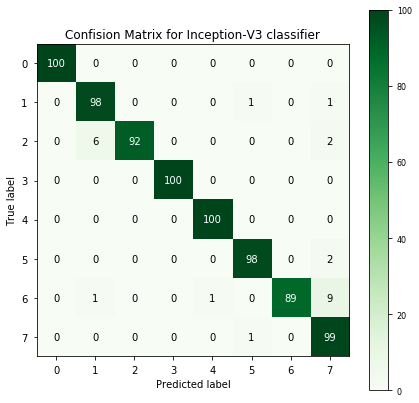

In [5]:
# Plotting the confusion matrix
cm = skplt.metrics.plot_confusion_matrix(ground_truth, predicted_classes, figsize=(
    7, 7), title="Confision Matrix for Inception-V3 classifier", cmap="Greens")
print(cm)

In [6]:
# Printing the classification report
target_names = ['3D T1 AX', '3DASG', 'DWI Trace',
                'MRA 3D TOF', 'PDSAG FSAT', 'T1 AX', 'T1 COR', 'WFS T1 AX']
cr = classification_report(
    ground_truth, predicted_classes, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

    3D T1 AX       1.00      1.00      1.00       100
       3DASG       0.93      0.98      0.96       100
   DWI Trace       1.00      0.92      0.96       100
  MRA 3D TOF       1.00      1.00      1.00       100
  PDSAG FSAT       0.99      1.00      1.00       100
       T1 AX       0.98      0.98      0.98       100
      T1 COR       1.00      0.89      0.94       100
   WFS T1 AX       0.88      0.99      0.93       100

   micro avg       0.97      0.97      0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



3D T1 AX  AUC: 1.000000
3DBASG AX AUC: 0.999300
DWI Trace AUC: 0.999329
MRA 3D TOF AUC: 1.000000
PDSAG FSAT AUC: 0.999986
T1 AX AUC: 0.999829
T1 COR AUC: 0.996186
WFS T1 AX AUC: 0.998029
Overall AUC: 0.999211


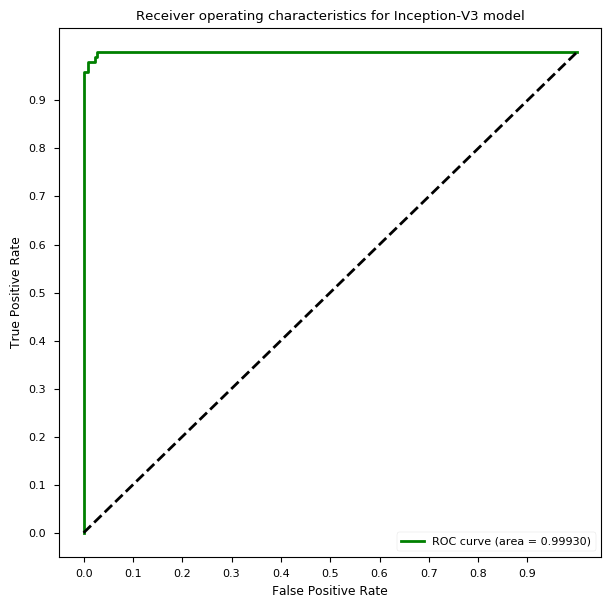

In [7]:
preds = pd.DataFrame(predictions, columns=label2index.keys())
preds['filename'] = fnames
preds['truth'] = preds['filename'].apply(os.path.dirname)
preds['predicted_class'] = preds[list(label2index.keys())].idxmax(1)
preds.head()

def get_truths(df, class_label):
    y_truth = df['truth'] == class_label
    return y_truth.astype(int).values, df[class_label].values

n_classes = len(label2index)
classes = label2index.keys()
lw = 2

# plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for k, i in label2index.items():
    t, p = get_truths(preds, k)
    fpr[i], tpr[i], _ = metrics.roc_curve(t, p)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# average it and compute AUC
mean_tpr /= n_classes
fpr["overall"] = all_fpr
tpr["overall"] = mean_tpr
roc_auc["overall"] = metrics.auc(fpr["overall"], tpr["overall"])

print_auc = (lambda x, v: print('{v} AUC: {x:.6f}'.format(v=v, x=x)))
for k, v in label2index.items():
    print_auc(roc_auc[v], k)
print_auc(roc_auc['overall'], "Overall")

fig = plt.figure(figsize=(7, 7), dpi=100)
ax = fig.add_subplot(1, 1, 1)
# Major ticks every 0.10, minor ticks every 0.10
major_ticks = np.arange(0.0, 1.0, 0.10)
minor_ticks = np.arange(0.0, 1.0, 0.10)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid('off')
plt.plot(fpr[1], tpr[1], color='g',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for Inception-V3 model')
plt.legend(loc="lower right")
plt.show()
##################################################################################################

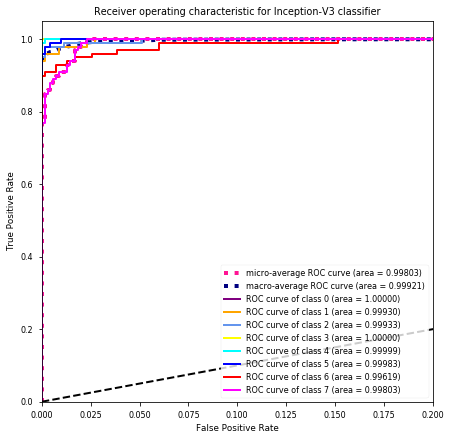

In [8]:
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for k, i in label2index.items():
    t, p = get_truths(preds, k)
    fpr[i], tpr[i], _ = roc_curve(t, p)
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(t.ravel(), p.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=[7, 7])
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['purple', 'orange', 'cornflowerblue',
                'yellow', 'cyan', 'blue', 'red', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 0.2])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Inception-V3 classifier')
plt.legend(loc="lower right")
fig.savefig('/home/francisanokye/Desktop/inceptaucroc.png')
plt.show()

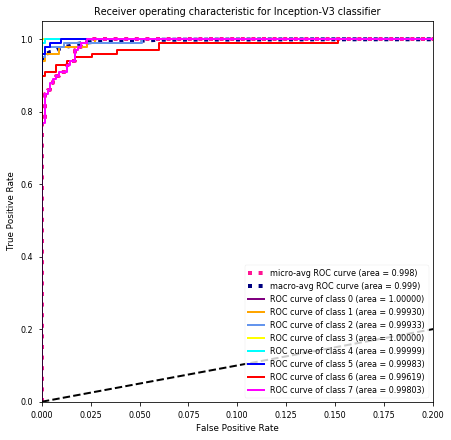

In [9]:
# Zoom in view of the upper left corner.
plt.figure(2, figsize=[7, 7])
plt.xlim(0, 0.2)
plt.ylim(0, 1.05)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-avg ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-avg ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['purple', 'orange', 'cornflowerblue',
                'yellow', 'cyan', 'blue', 'red', 'magenta'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
fig.savefig('/home/francisanokye/Desktop/inceptauc.png')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Inception-V3 classifier')
plt.legend(loc="lower right")
fig.savefig('/home/francisanokye/Desktop/inceptaucroc1.png')
plt.show()

IndexError: too many indices for array

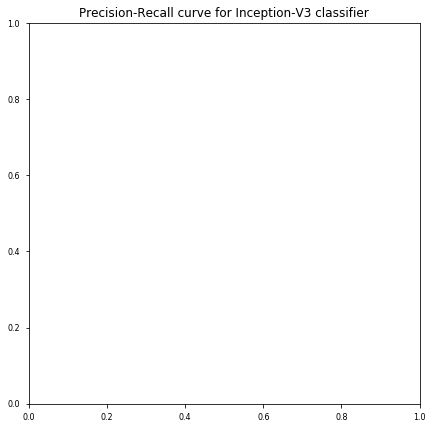

In [10]:
###########################################################################################
# Plot precision recall
pr = skplt.metrics.plot_precision_recall(ground_truth, predicted_classes, figsize=(
    7, 7), title="Precision-Recall curve for Inception-V3 classifier")
print(pr)

IndexError: too many indices for array

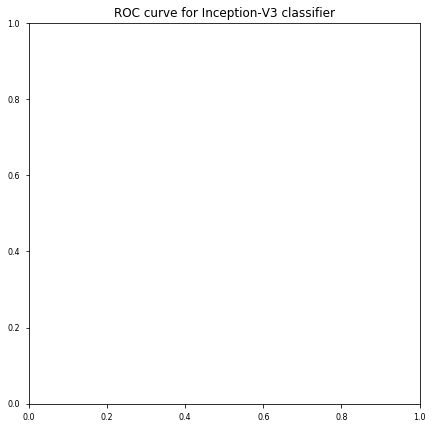

In [11]:
roc = skplt.metrics.plot_roc(ground_truth, predicted_classes, figsize=(
    7, 7), title="ROC curve for Inception-V3 classifier", plot_macro=True, plot_micro=True)
print(roc)

In [ ]:
########################################################################################################
# Show the errors
"""
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])

    original = load_img(
        '{}/{}'.format(test_data_path, fnames[errors[i]]))
    plt.figure(figsize=[4, 4])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

# Show the correct predictions
for i in range(len(correct)):
    pred_class = np.argmax(predictions[correct[i]])
    pred_label = idx2label[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[correct[i]].split('/')[0],
        pred_label,
        predictions[correct[i]][pred_class])

    original = load_img(
        '{}/{}'.format(test_data_path, fnames[correct[i]]))
    plt.figure(figsize=[4, 4])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
"""